# Lights model tutorial

In [1]:
%reset -f
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from tick.plot import plot_point_process
from lights.simulation import SimuJointLongitudinalSurvival
from lights.utils import heatmap, annotate_heatmap
from sklearn.model_selection import ShuffleSplit
from lifelines.utils import concordance_index as c_index_score
from IPython.display import Markdown, display
from scipy.stats import beta
from matplotlib import rc
rc('text', usetex=True)

def printmd(string):
    display(Markdown(string))

## Generate data

In [2]:
n_long_features = 5
simu = SimuJointLongitudinalSurvival(seed=123, n_long_features=n_long_features)
X, Y, T, delta = simu.simulate()

printmd("\nLevel of censoring: **%.2f%%**" % (100*(1 - delta.mean())))

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
--------------------------------------------------
Launching simulation using SimuHawkesExpKernels...
Done simulating using SimuHawkesExpKernels in 5.00e-03 seconds.
Done simulating using SimuJointLongitudinalSurvival in 1.68e-02 seconds.



Level of censoring: **34.20%**

### Visualize parameter vectors
We generate survival times with a risk model of the form
\begin{align}
\lambda_i(t|G_i = k) &= \lambda_0(t) \exp \Big\{ x_i^\top \xi + \sum_{l=1}^L \gamma_{k,1}^l (\beta_{k,1}^l + \beta_{k,2}^l t + b_{i,1}^l + b_{i,2}^l t) + (\gamma_{k,2,1}^l b_{i,1}^l + \gamma_{k,2,2}^l b_{i,2}^l) + \gamma_{k,3}^l (\beta_{k,2}^l + b_{i,2}^l) \Big\} \\
&= \lambda_0(t) \exp \big\{ \iota_{i,k,1} + \iota_{i,k,2} t \big\}
\end{align}

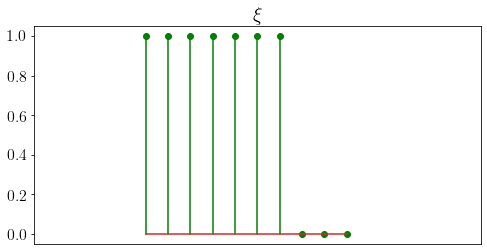

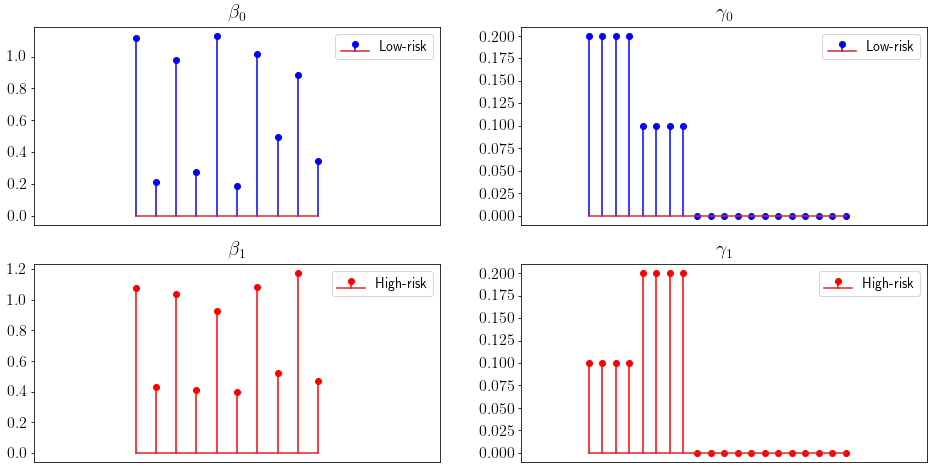

In [3]:
xi, betas, gammas = simu.xi, simu.betas, simu.gammas

fig = plt.figure(figsize=(8, 4))
fontsize = 16
ax = fig.add_subplot(111)
ax.stem(xi, linefmt='g-', markerfmt='go')
ax.set_xlim([-5, len(xi) + 5])
ax.set_title(r"$\xi$", fontsize=fontsize+4)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

fig = plt.figure(figsize=(16, 8))
names, colors, labels = ['beta', 'gamma'], ['b', 'r'], ['Low-risk', 'High-risk']
j = 1
for k in [0, 1]:
    for i, vectors in enumerate([betas, gammas]):
        name = names[i]
        ax = fig.add_subplot(2,2,j)
        j += 1
        ax.stem(vectors[k], linefmt='%s-' % colors[k], 
                markerfmt='%so' % colors[k], label=labels[k])
        ax.set_xlim([-5, len(vectors[k]) + 5])
        ax.set_title(r"$\%s_%s$" % (name, k), fontsize=fontsize+4)
        plt.yticks(fontsize=fontsize)
        plt.tick_params(axis='x', bottom=False, labelbottom=False)
        plt.legend(fontsize=fontsize-2)
plt.show()

### Visualize simulated times

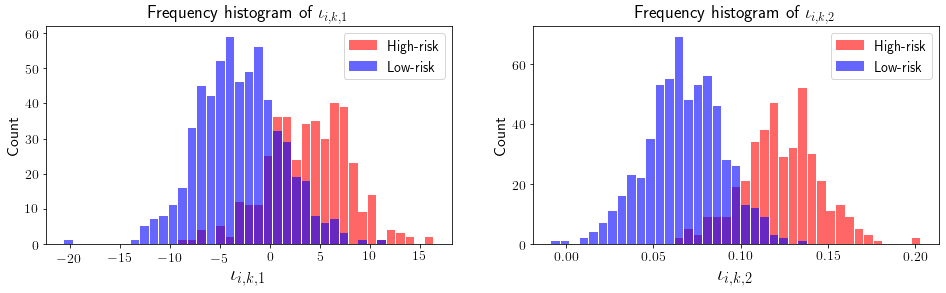

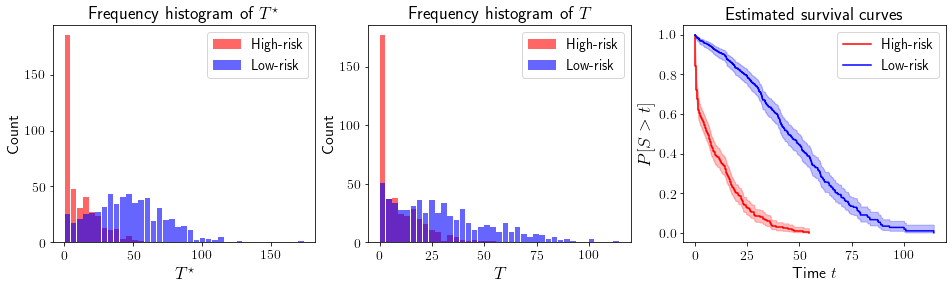

In [4]:
fig = plt.figure(figsize=(16, 4))
iotas = simu.iotas
for i in [1, 2]:
    ax = fig.add_subplot(1,2,i)
    iota_0i, iota_1i = iotas[i]
    all_iota = list(iota_0i) + list(iota_1i)
    mini, maxi = min(all_iota), max(all_iota)
    bins = np.linspace(mini, maxi, 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(iota_1i, **kwargs, color='r', label='High-risk')
    plt.hist(iota_0i, **kwargs, color='b', label='Low-risk')
    plt.xlabel(r"$\iota_{i,k,%s}$" % i, size=fontsize + 5)
    plt.ylabel("Count", size=fontsize)
    plt.legend(fontsize=fontsize-2)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$\iota_{i,k,%s}$' % i, size=fontsize+2)
plt.show()

fig = plt.figure(figsize=(16, 4))
G = simu.latent_class
T_star = simu.event_times
times, labels = [T_star, T], ['T^\star', 'T']
for i in [0, 1]:
    ax = fig.add_subplot(1,3,i+1)
    df = pd.DataFrame(data={"time": times[i], "group": G})
    bins = np.linspace(0, times[i].max(), 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(df.loc[df.group == 1, 'time'], **kwargs, color='r', label='High-risk')
    plt.hist(df.loc[df.group==0, 'time'], **kwargs, color='b', label='Low-risk')
    plt.legend(fontsize=fontsize-2)
    plt.xlabel(r'$%s$' % labels[i], size=fontsize+2)
    plt.ylabel("Count", size=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$%s$' % labels[i], size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(133)
kmf.fit(T[G == 1], delta[G == 1], label="High-risk").plot(ax=ax, c='r')
kmf.fit(T[G == 0], delta[G == 0], label="Low-risk").plot(ax=ax, c='b')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

### Visualize Hawkes Processes used to generate time measurements of longitudinal data

$\newcommand{\ind}[1]{1_{#1}}$
For a subject $i$, times $\{t_{ij}^l\}_{j \geq 1}$ for processes $l=1, \ldots, L$ are simulated using a multivariate Hawkes process $N_{it} = [N_{it}^1 \cdots N_{it}^L]$ with $t \geq 0$ and $N_{it}^l = \sum_{j \geq 1} \ind{\{t_{ij}^l \leq t\}}$. The process $N_{it}$ is a multivariate counting process, whose components $N_{it}^l$ have intensities
\begin{equation}
\lambda_i^l(t) = \Upsilon_{l} + \sum_{l'=1}^L \sum_{j \geq 1} A_{ll'} \upsilon \exp\big(-\upsilon(t - t_{ij}^{l'}) \big)
\end{equation}
for $l=1, \ldots, L$.

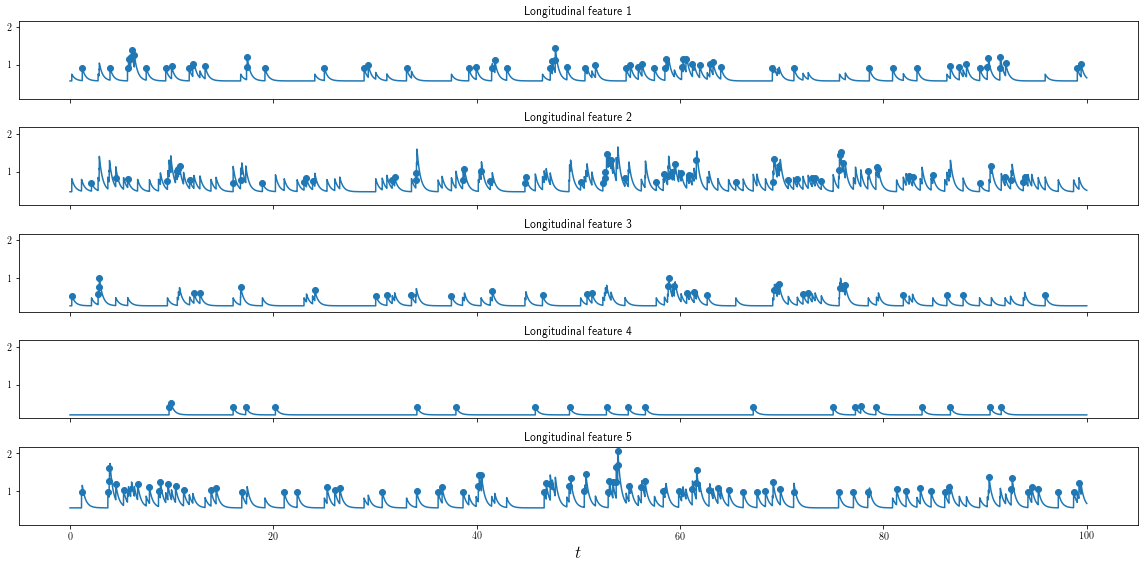

In [5]:
hawkes = simu.hawkes
adjacency = hawkes.adjacency

fig, ax = plt.subplots(n_long_features, 1, figsize=(16, 8), sharex=True, sharey=True)
long_features_names = ["Longitudinal feature %s" % (l + 1) for l in range(n_long_features)]
plot_point_process(hawkes, n_points=50000, ax=ax, node_names=long_features_names)
fig.tight_layout()

The matrix $A = [A_{ll'}]_{1 \leq l,l' \leq L}$ is the adjacency matrix such that $A_{ll'} \geq 0$ quantifies the impact of past measurement time of process $l'$ on the measurement time of process $l$, and $\upsilon \geq 0$ is a memory parameter.

We also plot the density of the law used to simulate $t_i^{max}$ with $(\nu_1, \nu_2) = (2,5)$, to mimic the fact that in practice, one has access to a reasonable amount of longitudinal data before making a prediction.

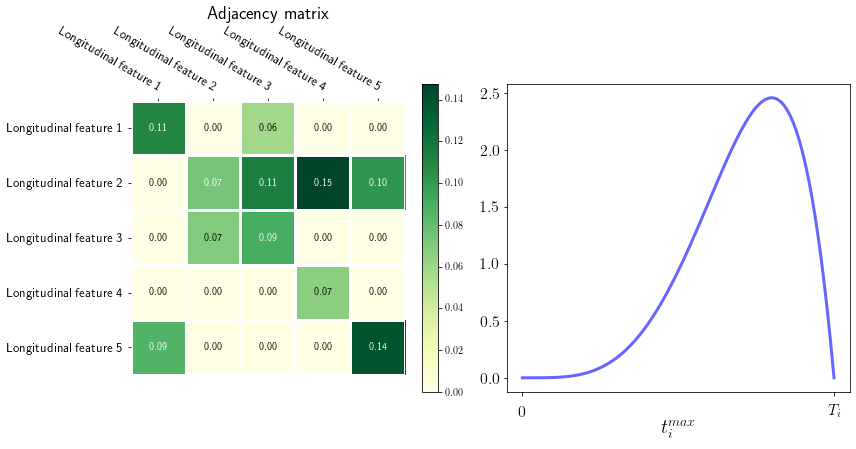

In [10]:
fig = plt.figure(figsize=(12, 6))
# Adjacency matrix
ax = fig.add_subplot(121)
im, cbar = heatmap(adjacency, long_features_names, long_features_names, ax=ax, cmap="YlGn")
texts = annotate_heatmap(im)
plt.title("Adjacency matrix", size=fontsize+2)

# Density of the law for the time up to which one has longitudinal data
ax = fig.add_subplot(122)
a, b = 2, 5
x = np.linspace(beta.ppf(0.0, a, b),
                beta.ppf(1, a, b), 100)
ax.plot(x, beta.pdf(1-x, a, b),
        'b-', lw=3, alpha=0.6)
labels = ['', r'$0$', r"$T_i$"]
plt.xlabel(r"$t_i^{max}$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.tick_params(axis='x', pad=10)
plt.locator_params(axis='x', nbins=2)
ax.set_xticklabels(labels)

fig.tight_layout()
plt.show()

## Data splitting

In [ ]:
## Assign index for each feature ##
features_names = range(X.shape[1]) 
n_samples, n_features = X.shape

## Split data into training and test sets ##
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X[test_index]
    delta_test = delta[test_index]
    Y_test = Y[test_index]

    X = X[train_index]
    Y = Y[train_index]
    delta = delta[train_index]  
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

## Training 

In [ ]:
## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'

# declare learner here        

## Cross-validation ##

## Run selected model with l_elasticNet_chosen ##

# run final fit here

## Prediction

In [ ]:
## Obtain the marker vector on test set ##

# prediction here

#c_index = c_index_score(Y_test, marker, delta_test)
#c_index = max(c_index, 1 - c_index)

print("Done predicting on test set.")
#print("C-index : %.2f" % c_index)

## Figures

### Learning curves

### Convergence

### Beta coefficients